In [136]:
import os
import email
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import unicodedata
import pandas as pd
from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


In [137]:
types = Counter()
msgs = []
trigger = True
for root,dirs,files in os.walk('/Users/austi/Downloads/SpamAssassinMessages/'):
    for f in files:
        with open(os.path.join(root,f),'r',encoding='latin-1') as file_handle:
            msg = email.message_from_file(file_handle,)
            type_ = msg.get_content_type()
            types[type_]+=1
            if type_ == 'multipart/mixed' and trigger:
                print(root,f)
                print('______________')
                trigger = False
                SAMPLE = msg.get_payload()
print(types)


/Users/austi/Downloads/SpamAssassinMessages/easy_ham 00067.23813c5ac6ce66fd892ee5501fd5dbd2
______________
Counter({'text/plain': 7413, 'text/html': 1193, 'multipart/alternative': 326, 'multipart/signed': 180, 'multipart/mixed': 179, 'multipart/related': 56, 'multipart/report': 5, 'text/plain charset=us-ascii': 1})


In [138]:
def return_txt(msg):
    text = "" 

    if msg.is_multipart():
        for item in msg.get_payload():
            text += return_txt(item)
    else:
        if msg.get_content_type() == 'text/plain':
            text += msg.get_payload()
        elif msg.get_content_type() == 'text/html':
            html_content = msg.get_payload(decode=True)
            soup = BeautifulSoup(html_content, 'html.parser')
            text += soup.get_text()
        else:
            text += msg.get_payload(decode=True).decode('utf-8', errors='ignore')

    return text


In [139]:
def extract_message_type(message):
    if message.is_multipart():
        return 'multipart'
    else:
        return message.get_content_type()

In [140]:
#### this was giving me some issues when working with it and trying to combine html stuff


# file_names = []
# label = []
# messages = []
# msgType = []
# htmlMsgs = []
# msgToFix = []

# for root, dirs, files in os.walk('/Users/austi/Downloads/SpamAssassinMessages/'):
#     for f in files:
#         with open(os.path.join(root, f), 'r', encoding='latin-1') as file_handle:
#             msg = email.message_from_file(file_handle)
#             text = return_txt(msg)
#             if msg.get_content_type() == 'text/html':
#                 htmlMsgs.append([text, root, f])
#             else:
#                 messages.append(text)
#                 if 'spam' in root:
#                     label.append(1)
#                 else:
#                     label.append(0)

In [141]:
file_names = []
labels = []
messages = []
message_types = []

for root, dirs, files in os.walk('/Users/austi/Downloads/SpamAssassinMessages/'):
    for file in files:
        file_path = os.path.join(root, file)
        
        with open(file_path, 'r', encoding='latin-1') as file_handle:
            msg = email.message_from_file(file_handle)
            text = return_txt(msg)
            
            # This jsut gets rid fo escape characters.. found from stack overfow
            text = ''.join([c for c in text if not unicodedata.category(c).startswith('C')])
            
            messages.append(text)
            
            label = 1 if 'spam' in root else 0
            labels.append(label)
            
            message_type = extract_message_type(msg)
            message_types.append(message_type)
            
        file_names.append(file_path)

data = {
    'File Name': file_names,
    'Label': labels,
    'Message': messages,
    'Message Type': message_types
}

df = pd.DataFrame(data)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [142]:
df.tail(50)

,File Name,Label,Message,Message Type
9303,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,Lowest rates available for term life insurance...,text/plain
9304,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,Ricardo Olá Trabalhodivulgando empresas s...,text/html
9305,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,______________________________________________...,text/html
9306,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,We offer some of the best bulk e-mail prices o...,text/plain
9307,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,----------------------------------------------...,text/plain
9308,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,18 - 21 YR. OLD CHICKS ARE SO HORNY!NASTY AMAT...,text/html
9309,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,Norton SystemWorks 2002Software SuiteProfessio...,text/html
9310,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,Dear SirWe fetch your name by internet.This mo...,multipart
9311,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,Dental Plans For $6.95 Per MonthDental Plans F...,text/html
9312,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,Below is the result of your feedback form. It...,text/plain


In [143]:
message_type_counts = df['Message Type'].value_counts()

print(message_type_counts)

Message Type
text/plain                     7413
text/html                      1193
multipart                       743
multipart/alternative             3
text/plain charset=us-ascii       1
Name: count, dtype: int64


In [144]:
for file in msgToFix:
    with open(file,'r',encoding='latin-1') as badFile:
        msg = email.message_from_file(badFile)
        for m in msg:
            print(m[2])

In [145]:
#### Did not have enough memory.. revised to mini batch kmeans

# vectorizer = CountVectorizer()
# textVector = vectorizer.fit_transform(messages)
# kMeans = KMeans(random_state=42)
# kMeans.fit(textVector)
# textData = textVector.toarray()
# textData.shape
# cluster_column = np.array(kMeans.labels_).reshape(-1, 1)
# textClusters = np.hstack((textData,cluster_column))
# textClusters.shape
# nb = MultinomialNB()
# nb.fit(textClusters,label)
# cross_val_score(nb,textClusters,label,cv=5,n_jobs=-1,scoring='accuracy')


In [146]:
vectorizer = CountVectorizer()
textVector = vectorizer.fit_transform(messages)

batch_size = 2000  
n_clusters = 2
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(textVector)

labels = kmeans.labels_
df['Cluster Label'] = labels
df

C:\Users\austi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


,File Name,Label,Message,Message Type,Cluster Label
0,/Users/austi/Downloads/SpamAssassinMessages/ea...,0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",text/plain,1
1,/Users/austi/Downloads/SpamAssassinMessages/ea...,0,"Martin A posted:Tassos Papadopoulos, the Greek...",text/plain,1
2,/Users/austi/Downloads/SpamAssassinMessages/ea...,0,Man Threatens Explosion In Moscow Thursday Aug...,text/plain,0
3,/Users/austi/Downloads/SpamAssassinMessages/ea...,0,Klez: The Virus That Won't Die Already the mos...,text/plain,1
4,/Users/austi/Downloads/SpamAssassinMessages/ea...,0,"> in adding cream to spaghetti carbonara, whi...",text/plain,1
...,...,...,...,...,...
9348,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,Preferred Non-Smoker Just what the doctor o...,multipart,1
9349,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,"Dear Subscriber,If I could show you a way to g...",text/plain,0
9350,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,****Mid-Summer Customer Appreciation SALE!****...,text/plain,0
9351,/Users/austi/Downloads/SpamAssassinMessages/sp...,1,ATTN:SIR/MADAN STRI...,text/plain,0


In [147]:
X_train, X_test, y_train, y_test = train_test_split(textVector, 
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)


alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]

for alpha in alpha_values:

    nb_classifier = MultinomialNB(alpha = alpha)
    nb_classifier.fit(X_train, y_train)

    y_pred = nb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f'Alpha = {alpha}\n{report}\n')
    print(f'Accuracy: {accuracy}')
    print('--------------------------------------------------------')

Alpha = 0.001
              precision    recall  f1-score   support

     Class 0       0.47      0.90      0.62       428
     Class 1       0.96      0.70      0.81      1443

    accuracy                           0.75      1871
   macro avg       0.72      0.80      0.71      1871
weighted avg       0.85      0.75      0.77      1871


Accuracy: 0.8915018706574025
--------------------------------------------------------
Alpha = 0.01
              precision    recall  f1-score   support

     Class 0       0.47      0.90      0.62       428
     Class 1       0.96      0.70      0.81      1443

    accuracy                           0.75      1871
   macro avg       0.72      0.80      0.71      1871
weighted avg       0.85      0.75      0.77      1871


Accuracy: 0.8813468733297701
--------------------------------------------------------
Alpha = 0.1
              precision    recall  f1-score   support

     Class 0       0.47      0.90      0.62       428
     Class 1       0.96 

In [148]:
alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]

accuracies = []
classification_reports = []

X_train, X_test, y_train, y_test = train_test_split(textVector, labels, test_size=0.2, random_state=42)

for alpha in alpha_values:
    nb_classifier = MultinomialNB(alpha=alpha)
    
    cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=5)
    
    nb_classifier.fit(X_train, y_train)
    
    y_pred = nb_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    
    accuracies.append(accuracy)
    classification_reports.append(classification_rep)
    
    print(f'Alpha = {alpha}:')
    print('Cross-Validation Scores:', cv_scores)
    print('Mean Cross-Validation Accuracy:', cv_scores.mean())
    print('--------------------------------------------------------\n')
    

Alpha = 0.001:
Cross-Validation Scores: [0.88510354 0.88376754 0.88235294 0.88636364 0.8790107 ]
Mean Cross-Validation Accuracy: 0.8833196696423149
--------------------------------------------------------

Alpha = 0.01:
Cross-Validation Scores: [0.88777555 0.88510354 0.87834225 0.88903743 0.8776738 ]
Mean Cross-Validation Accuracy: 0.883586513490439
--------------------------------------------------------

Alpha = 0.1:
Cross-Validation Scores: [0.88510354 0.87909152 0.87433155 0.87967914 0.8709893 ]
Mean Cross-Validation Accuracy: 0.8778390113560455
--------------------------------------------------------

Alpha = 0.5:
Cross-Validation Scores: [0.8496994  0.85504342 0.84491979 0.84959893 0.82754011]
Mean Cross-Validation Accuracy: 0.8453603285001374
--------------------------------------------------------

Alpha = 1.0:
Cross-Validation Scores: [0.82297929 0.81897128 0.81550802 0.81417112 0.7934492 ]
Mean Cross-Validation Accuracy: 0.8130157820096521
------------------------------------

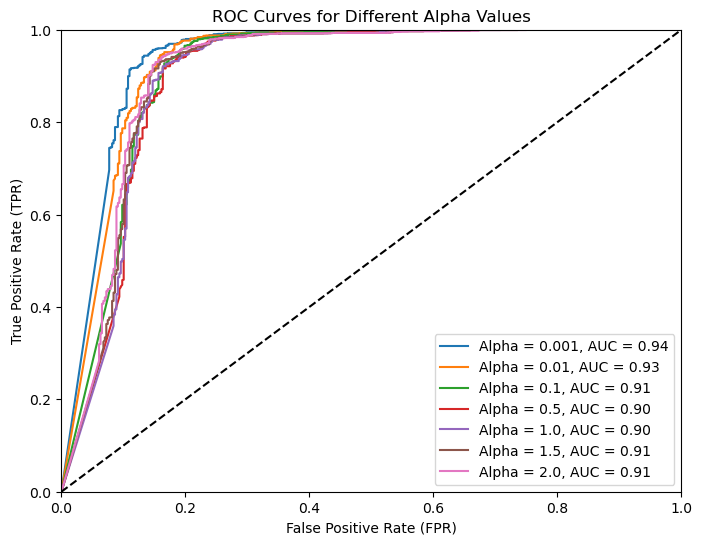

In [149]:
alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]

plt.figure(figsize=(8, 6))
for alpha in alpha_values:
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(X_train, y_train)

    y_prob = nb_classifier.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    roc_auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, label=f'Alpha = {alpha}, AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Different Alpha Values')
plt.legend(loc='lower right')
plt.show()
